# i. Introduction

Background: 
I am a data scientist at PT. ABC, and I have been assigned a project to manage a dataset related to user payment credit scores. My task is to select the appropriate model to use on this dataset and provide predictions regarding whether users will be able to pay for the next month or not, based on their historical data.

Problem Statement: 
The objective of this project is to predict users' ability to make payments in order to reduce the number of users who are unable to pay by 10% within a 3-month timeframe, thereby minimizing losses for PT. ABC.

Hugging Face : https://huggingface.co/spaces/kennethv1706/Dataset_Credit_Score


# ii. SQL Query

SQL syntax for selecting which columns to use for

```sql
SELECT
    limit_balance,
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 19950;
```

# iii. Import Libraries 

In [1]:
#module for preparation and display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau
import pickle


#module for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer , OutlierTrimmer
from imblearn.over_sampling import SMOTENC
from statsmodels.stats.outliers_influence import variance_inflation_factor

#module for library model 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# iv. Data Loading

In [2]:
#loading CSV data that has been saved into CSV form from BigQuery
df=pd.read_csv('credit_score.csv')

In [3]:
#displays top 10 data
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [4]:
#displays the bottom 10 data
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


# v. Exploratory Data Analysis (EDA)

## Data Info

In [5]:
#display column details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [6]:
#check whether there are missing data values
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Here are the details of the 24 columns with descriptions:
- limit_balance : amount of credit given to customers (in NT dollars)
- sex: gender (1=male, 2=female)
- education_level : education level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- marital_status : marital status (1=married, 2=single, 3=others)
- age: age in years
- pay_0: payment status in September, 2005
  (-1=paid in full,
    1 = delay for one month,
    2= ​​delay of two months, …
    8= delay of eight months,
    9 = delay of nine months or more).
- pay_2: payment status in August, 2005 (same scale as above)
- pay_3: payment status in July, 2005 (same scale as above)
- pay_4: payment status in June, 2005 (same scale as above)
- pay_5: payment status in May, 2005 (same scale as above)
- pay_6: payment status in April, 2005 (same scale as above)
- bill_amt1: Monthly billing statement amount in September, 2005 (in NT dollars)
- bill_amt2: Monthly billing statement amount in August, 2005 (in NT dollars)
- bill_amt3: Monthly billing statement amount in July, 2005 (in NT dollars)
- bill_amt4: Monthly billing statement amount in June, 2005 (NT dollars)
- bill_amt5: Monthly billing statement amount in May, 2005 (in NT dollars)
- bill_amt6: Monthly billing statement amount in April, 2005 (in NT dollars)
- pay_amt1: Previous payment amount in September, 2005 (in NT dollars)
- pay_amt2: Previous payment amount in August, 2005 (in NT dollars)
- pay_amt3: Previous payment amount in July, 2005 (in NT dollars)
- pay_amt4: Previous payment amount in June, 2005 (in NT dollars)
- pay_amt5: Previous payment amount in May, 2005 (in NT dollars)
- pay_amt6: Previous payment amount in April, 2005 (in NT dollars)
- default_payment_next_month: Failed payment next month (1=yes, 0=no)

## Data Cleaning

In [7]:
#rename columns to make them shorter and in order
df.rename(columns={'default_payment_next_month':'def_payment'}, inplace=True)
df.rename(columns={'pay_0':'pay_1'}, inplace=True)

In [8]:
#check data duplication
df[df.duplicated(keep=False)]

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,def_payment
2806,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2815,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
#remove double index
index_to_remove = 2806
df1 = df.drop(index_to_remove)

## Business Knowledge

c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


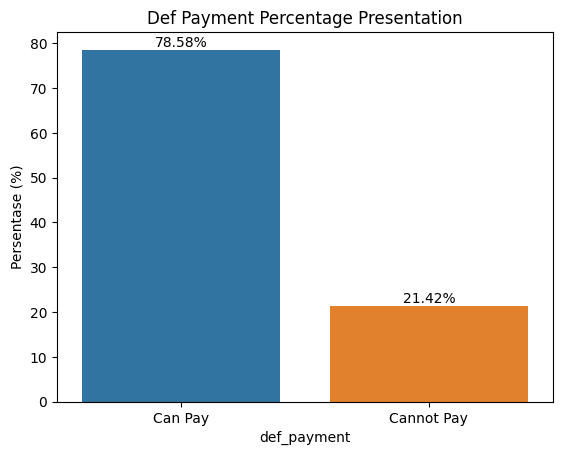

In [10]:
#make a barplot showing the percentage of people who can pay or not
count_data = df1['def_payment'].value_counts()

total_data = len(df1)

percentage_data = (count_data / total_data) * 100

sns.barplot(x=percentage_data.index, y=percentage_data.values)

plt.title('Def Payment Percentage Presentation')
plt.xlabel('def_payment')
plt.ylabel('Persentase (%)')

for i in range(len(percentage_data)):
    plt.text(i, percentage_data[i], f'{percentage_data[i]:.2f}%', ha='center', va='bottom')
plt.xticks([0, 1],
           ['Can Pay', 'Cannot Pay'])
plt.show()


Results: 
We can see that 78.58% can pay and 21.42% cannot pay

c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

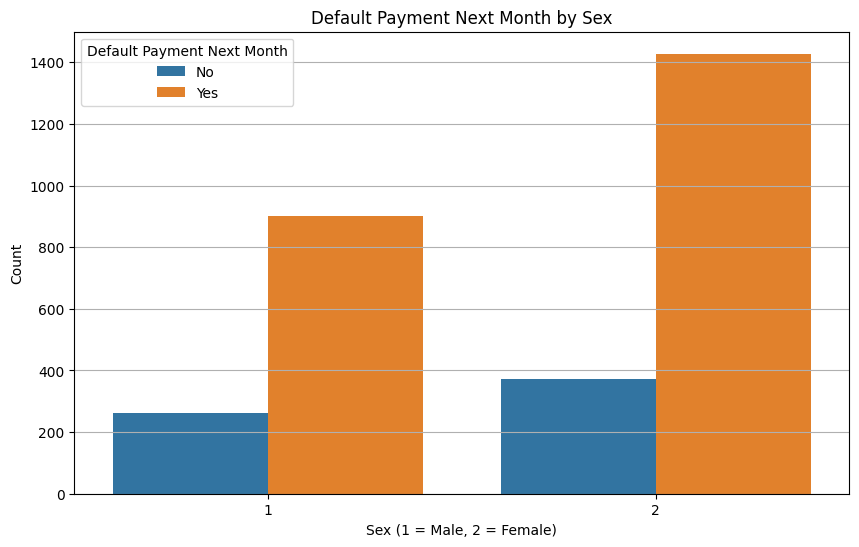

In [11]:
# Data visualization of 'sex' column based on 'default_payment_next_month'
#create dummy data for this visualization and change sex dan def_payment to string
df3=df1.copy()
df3['sex'] = df1['sex'].astype(str)
df3['def_payment'] = df1['def_payment'].astype(str)


plt.figure(figsize=(10, 6))
sns.countplot(x='sex', hue='def_payment', data=df3)

# Enhancing the plot
plt.title('Default Payment Next Month by Sex')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Count')
plt.legend(title='Default Payment Next Month', labels=['No', 'Yes'])
plt.grid(axis='y')

# Display the plot
plt.show()

Result:
It can be seen that the majority of users are women. It can be said that the users are housewives and career women compared to men who are fewer in number.

c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


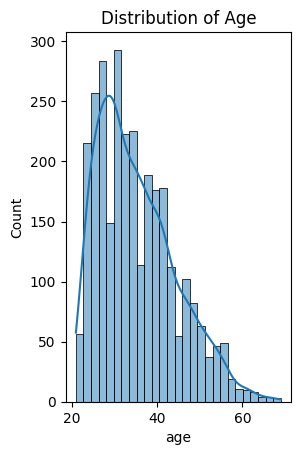

In [12]:
#create histogram for distribution age
plt.subplot(1, 2, 2)
sns.histplot(df1['age'], kde=True)
plt.title('Distribution of Age')

plt.show()

Results: It can be seen that the age distribution is from 20 to 50
Insight : To increase the number of users who can pay, it's a good idea to bill on payday around 25-31 during payday because on that date they have a lot of money so they can pay.

In [13]:
#shorten cardinality
df1['education_level'] = df1['education_level'].apply(lambda x: 4 if x in [0, 5, 6] else x)

c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


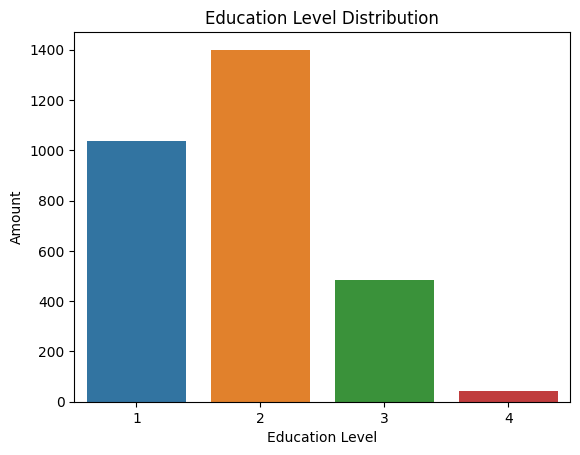

In [14]:
#display educational level plot
sns.countplot(x='education_level', data=df1)
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Amount')
plt.show()

Notes: 1 Graduate, 2 University, 3 High School, 4 Others
Results: It can be seen from this that the majority of users are graduates and universities. Maybe in the future a threshold can be selected or given for users who can use this facility because users with high school level education, others may not have income or their income is small so it will be more likely for them to fail to pay. When we set a threshold for users with a large or fixed income, we can reduce the percentage of defaults.

## Cek Kolerasi

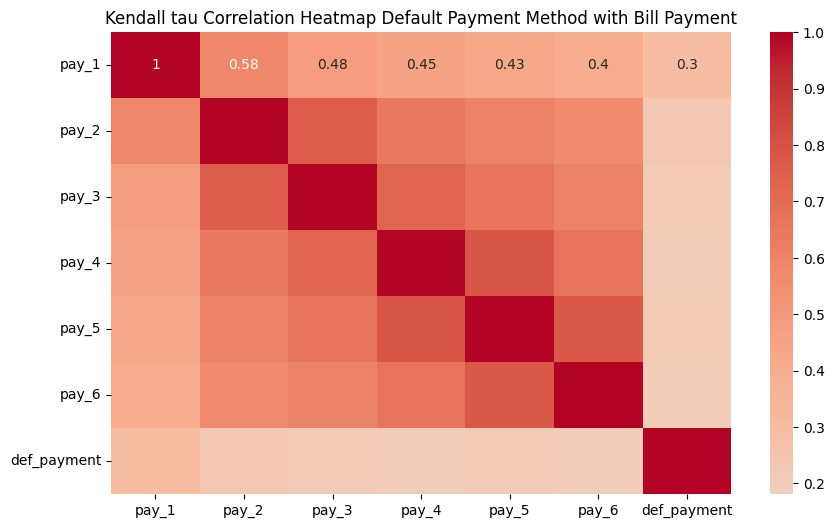

In [15]:
#Calculate the correlation of def_payment with 'pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6'
#I used Kendall because after checking again that the data was categorical
billcol = df1[['pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6','def_payment']]

kendall_corr_matrix = billcol.corr(method=lambda x, y: kendalltau(x, y).correlation)

plt.figure(figsize=(10, 6))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Kendall tau Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

Results: From the heatmap it can be seen that 'pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6' have a correlation with the def_payment column so that these columns will be included in the feature selection

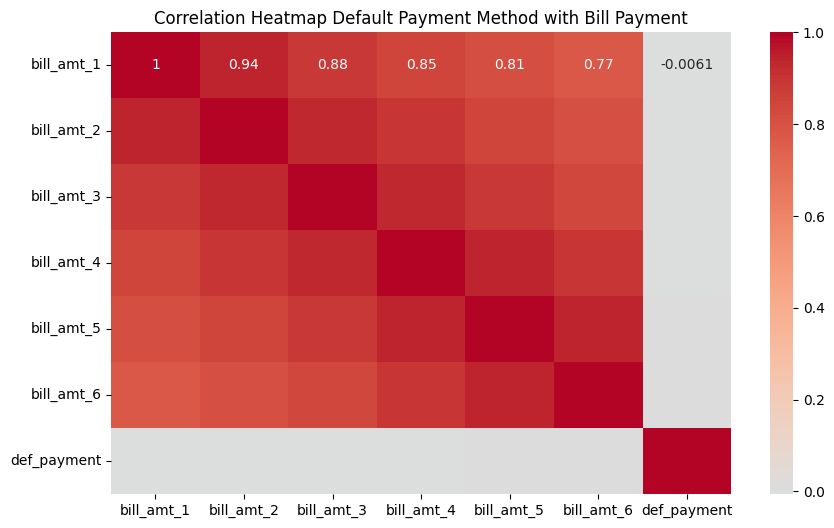

In [16]:
#Calculate def_payment correlation with 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4','bill_amt_5','bill_amt_6'
repaymentcol = df1[['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4','bill_amt_5','bill_amt_6','def_payment']]

plt.figure(figsize=(10, 6))
sns.heatmap(repaymentcol.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

Results: From the heatmap it can be seen that there are no columns that have a correlation with the def_payment column so these columns will not be included in the feature selection

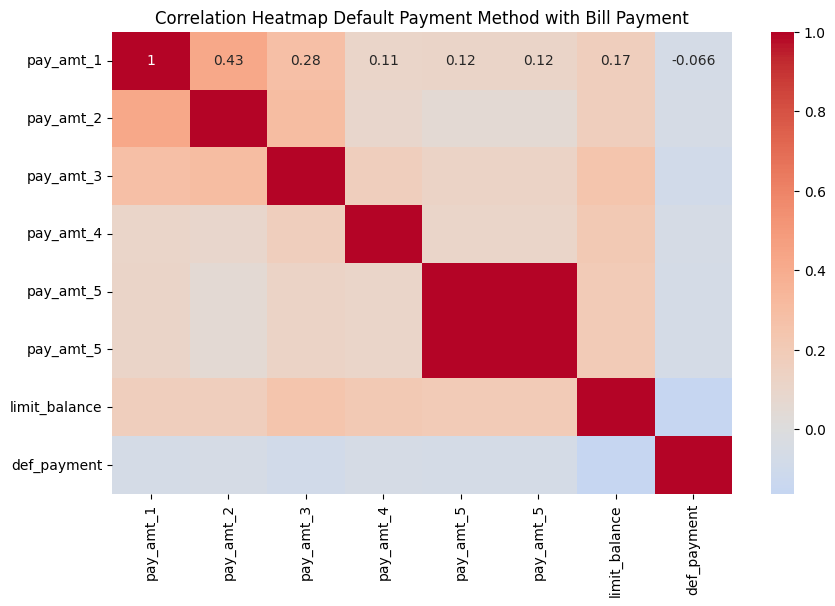

In [17]:
#Calculate def_payment correlation with 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4','pay_amt_5','pay_amt_5','limit_balance'
pay_amt_corr = df1[['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4','pay_amt_5','pay_amt_5','limit_balance','def_payment']]

plt.figure(figsize=(10, 6))
sns.heatmap(pay_amt_corr.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

Results: From the heatmap it can be seen that 'limit_balance' has a correlation with the def_payment column so that these columns will be included in the feature selection

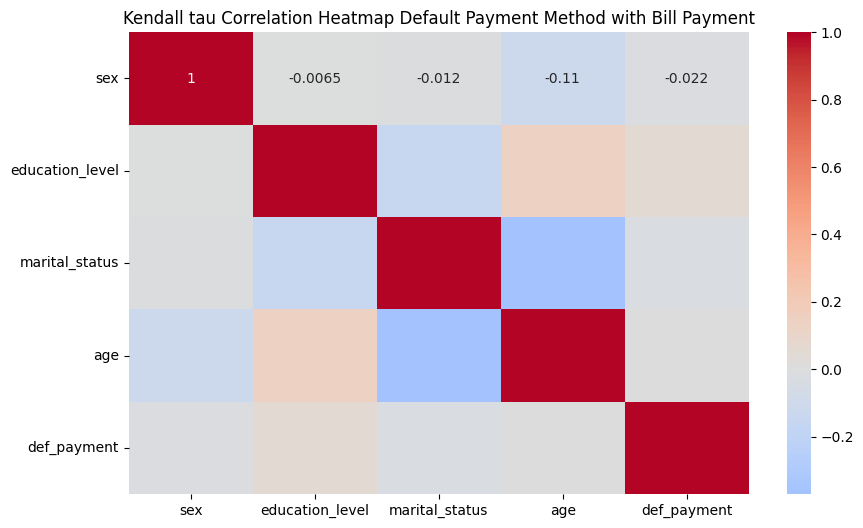

In [18]:
#Calculate def_payment correlation with 'sex', 'education_level', 'marital_status', 'age'
#I used Kendall because after checking again that the data was categorical
status_corr = df1[['sex', 'education_level', 'marital_status', 'age', 'def_payment']]

kendall_corr_matrix = status_corr.corr(method=lambda x, y: kendalltau(x, y).correlation)

plt.figure(figsize=(10, 6))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Kendall tau Correlation Heatmap Default Payment Method with Bill Payment')
plt.show()

Results: From the heatmap it can be seen that there are no columns that have a correlation with the def_payment column so these columns will not be included in the feature selection

### Feature Selection

In [19]:
#create a new variable as a feature selection
df_fix = df1[['limit_balance','pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6','def_payment']]

In [20]:
#call data that has been in feature selection
df_fix

,limit_balance,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,def_payment
0,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,260000.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,150000.0,0.0,0.0,0.0,-1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
2960,80000.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,0
2961,50000.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1
2962,450000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1
2963,50000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0


## Cardinality

In [21]:
#calculating cardinality
cols_cat= df_fix[['pay_1','pay_2','pay_3','pay_4','pay_5','pay_6']]

for i in cols_cat.columns:
    print(f'cardinality kolom {i}:', cols_cat[i].nunique())

cardinality kolom pay_1: 11
cardinality kolom pay_2: 10
cardinality kolom pay_3: 9
cardinality kolom pay_4: 10
cardinality kolom pay_5: 9
cardinality kolom pay_6: 8


Result: After checking that the cardinality in the columns 'pay_1','pay_2','pay_3','pay_4','pay_5','pay_6' is at most 11 and is still within normal limits in my opinion so it doesn't need to be handled

# vi. Feature Engineering

In [22]:
#divide the data that has been in future selection into x and y with y being the target def_payment column
X= df_fix.drop('def_payment', axis=1) #fitur
y= df_fix['def_payment'] #target

In [23]:
#split data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,stratify=y)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)
print('Train Size : ', y_train.shape)
print('Test Size  : ', y_test.shape)

Train Size :  (2371, 7)
Test Size  :  (593, 7)
Train Size :  (2371,)
Test Size  :  (593,)


## Handling Outlier

In [24]:
#calculate the distribution of data types using the skewness method
print(f"Skewness dari distance :{X_train['limit_balance'].skew()}")

Skewness dari distance :0.9529337693438512


In [25]:
#remove outliers in the limit_balance column in X train with tukey because the x train skewness is close to 1 and the outliers are less than 5%
Trimmer_price = OutlierTrimmer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=['limit_balance'])

X_train_trimmer = Trimmer_price.fit_transform(X_train)

## Handling Missing Value

In [26]:
#when checked there are no missing values ​​in the x train so it doesn't need to be handle
X_train.isnull().sum()

limit_balance    0
pay_1            0
pay_2            0
pay_3            0
pay_4            0
pay_5            0
pay_6            0
dtype: int64

In [27]:
#when checked there are no missing values ​​in the x test so it doesn't need to be handle
X_test.isnull().sum()

limit_balance    0
pay_1            0
pay_2            0
pay_3            0
pay_4            0
pay_5            0
pay_6            0
dtype: int64

## Scaling

In [28]:
#scaling using minmax because the data skew is not normal
scaler = MinMaxScaler()
model = scaler.fit(X_train_trimmer[['limit_balance']])
train_scaller = model.transform(X_train_trimmer[['limit_balance']])
test_scaller = scaler.transform(X_test[['limit_balance']])

In [29]:
#call the limit balance column in a train that has been scaled
train_scaller

array([[0.58],
       [0.5 ],
       [0.56],
       ...,
       [0.24],
       [0.14],
       [0.24]])

In [30]:
#call the limit balance column in the test which has been scaled
test_scaller

array([[0.12],
       [0.08],
       [0.4 ],
       [0.14],
       [0.22],
       [0.22],
       [0.22],
       [0.08],
       [0.7 ],
       [0.7 ],
       [0.68],
       [0.08],
       [0.08],
       [0.46],
       [0.54],
       [0.08],
       [0.02],
       [0.24],
       [0.56],
       [0.16],
       [0.08],
       [0.18],
       [0.08],
       [0.38],
       [0.54],
       [0.24],
       [0.08],
       [0.26],
       [0.8 ],
       [0.36],
       [0.1 ],
       [0.36],
       [0.7 ],
       [0.5 ],
       [0.38],
       [0.26],
       [0.38],
       [0.34],
       [0.42],
       [0.58],
       [0.08],
       [0.04],
       [0.06],
       [0.66],
       [0.08],
       [1.54],
       [0.7 ],
       [0.04],
       [0.38],
       [0.54],
       [0.32],
       [0.46],
       [0.28],
       [0.46],
       [0.08],
       [0.4 ],
       [0.12],
       [0.4 ],
       [0.14],
       [0.48],
       [0.5 ],
       [0.42],
       [0.08],
       [0.6 ],
       [0.58],
       [0.42],
       [0.

## Combining data that has been in data preprocessing

In [31]:
#create a new variable to hold the categorical columns in x train and x test
X_train_cat=X_train_trimmer[['pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6']]
X_test_cat=X_test[['pay_1', 'pay_2', 'pay_3', 'pay_4','pay_5','pay_6']]


In [32]:
#combine the results of x trains. and x test numerical and x train categorical which have been data preprocessed
X_train_final = np.concatenate([train_scaller, X_train_cat], axis=1)
X_test_final = np.concatenate([test_scaller, X_test_cat], axis=1)

In [33]:
#call the final x train that has been merged
X_train_final

array([[ 0.58,  0.  ,  0.  , ...,  0.  ,  0.  ,  2.  ],
       [ 0.5 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.56,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.24,  0.  ,  0.  , ...,  0.  , -2.  , -2.  ],
       [ 0.14,  2.  ,  2.  , ...,  2.  ,  0.  ,  0.  ],
       [ 0.24, -1.  ,  2.  , ...,  2.  , -1.  , -1.  ]])

In [34]:
#call the final x test that has been merged
X_test_final

array([[ 0.12,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.08,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.4 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.36,  0.  ,  0.  , ...,  0.  ,  0.  , -1.  ],
       [ 0.08,  0.  ,  0.  , ...,  0.  ,  2.  ,  0.  ],
       [ 0.48,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [35]:
#equalize the index on y train and y test with the loc function
y_train = y_train.loc[X_train_trimmer.index]
y_test = y_test.loc[X_test.index]

In [36]:
X_train_final

array([[ 0.58,  0.  ,  0.  , ...,  0.  ,  0.  ,  2.  ],
       [ 0.5 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.56,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.24,  0.  ,  0.  , ...,  0.  , -2.  , -2.  ],
       [ 0.14,  2.  ,  2.  , ...,  2.  ,  0.  ,  0.  ],
       [ 0.24, -1.  ,  2.  , ...,  2.  , -1.  , -1.  ]])

## SmotheNC 

In [37]:
#perform smotenc to balance data
smotenc = SMOTENC([1,2,3,4,5,6], random_state = 66)
x_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_final, y_train)
y_train_balanced.value_counts()

def_payment
0    1855
1    1855
Name: count, dtype: int64

In [38]:
#create a new variable for data that has been balanced
X_train_finals= x_train_balanced
y_trains= y_train_balanced

# vii Model Definition

## Logistic regression

In [39]:
#define the Logistic Repression model
model_logreg = LogisticRegression()
model_logreg.fit(X_train_finals, y_trains)

print('Coefficient : ', model_logreg.coef_)
print('Intercept   : ', model_logreg.intercept_)

Coefficient :  [[-0.90840624  0.61806286 -0.07365562  0.15539639 -0.07593628  0.04412125
   0.12469467]]
Intercept   :  [0.10615282]


These results from the logistic regression model show that there are several independent variables that have a significant influence on the dependent variable, with positive and negative coefficients indicating the direction of the relationship, as well as a positive intercept value indicating the basic probability of the dependent variable.

In [40]:
#see the default value of the logistic regression model from x train data
y_train_predict_logreg = model_logreg.predict(X_train_finals)
print('----------default Logistic Regression-------------')
print(classification_report(y_trains,y_train_predict_logreg))

----------default Logistic Regression-------------
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1855
           1       0.70      0.65      0.67      1855

    accuracy                           0.68      3710
   macro avg       0.68      0.68      0.68      3710
weighted avg       0.68      0.68      0.68      3710



In [41]:
#see the default value of the logistic regression model from x test data
y_test_predict_logreg = model_logreg.predict(X_test_final)
print('----------default Logistic Regression-------------')
print(classification_report(y_test,y_test_predict_logreg))

----------default Logistic Regression-------------
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       466
           1       0.38      0.61      0.47       127

    accuracy                           0.70       593
   macro avg       0.62      0.67      0.63       593
weighted avg       0.77      0.70      0.72       593



seen from the default Logistic Regression f1_score value, it has a train range value of 0.67 and test 0.47

KNN

In [42]:
#define KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_finals, y_trains)

KNeighborsClassifier()

In [43]:
#see the default value of the KNN model from x train data
y_train_predict_knn = knn.predict(X_train_finals)
print('----------default KNN-------------')
print(classification_report(y_trains,y_train_predict_knn))

----------default KNN-------------
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1855
           1       0.86      0.72      0.79      1855

    accuracy                           0.80      3710
   macro avg       0.81      0.80      0.80      3710
weighted avg       0.81      0.80      0.80      3710



In [44]:
#see the default value of the KNN model from the x test data
y_test_predict_knn = knn.predict(X_test_final)
print('----------default KNN-------------')
print(classification_report(y_test,y_test_predict_knn))

----------default KNN-------------
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       466
           1       0.47      0.49      0.48       127

    accuracy                           0.77       593
   macro avg       0.66      0.67      0.67       593
weighted avg       0.78      0.77      0.77       593



seen from the default KNN f1_score value, it has a train range value of 0.79 and test 0.48

SVM

In [45]:
#define SVM model
svm_scaled = SVC()
svm_scaled.fit(X_train_finals, y_trains)

SVC()

In [46]:
#see the default value of the SVM model from x train data
y_train_predict_svm = svm_scaled.predict(X_train_finals)
print('----------default SVM-------------')
print(classification_report(y_trains,y_train_predict_svm))

----------default SVM-------------
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      1855
           1       0.84      0.56      0.67      1855

    accuracy                           0.73      3710
   macro avg       0.75      0.73      0.72      3710
weighted avg       0.75      0.73      0.72      3710



In [47]:
#see the default value of the SVM model from x test data
y_test_predict_svm = svm_scaled.predict(X_test_final)
print('----------default SVM-------------')
print(classification_report(y_test,y_test_predict_svm))

----------default SVM-------------
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       466
           1       0.55      0.52      0.53       127

    accuracy                           0.80       593
   macro avg       0.71      0.70      0.70       593
weighted avg       0.80      0.80      0.80       593



seen from the default SVM f1_score value, it has a train range value of 0.67 and test 0.53

## Cross Validation

Here I carry out cross validation on 3 models including Logistic Regression, KNN and SVM. From the cross validation results, the best model will be taken for hypermeter paratuning, training and evaluation. I use the F1 score assessment because I consider precision and recall to be important

### cross validation dengan metode logistec regession

In [48]:
%%time
f1_train_cross_val = cross_val_score(model_logreg,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.68938401 0.62857143 0.66199158 0.697609   0.68775791]
F1 Score - Mean - Cross Validation :  0.6730627869063035
F1 Score - Std - Cross Validation  :  0.02524637830058187
F1 Score - Range of Test-Set       :  0.6478164086057216 - 0.6983091652068854
CPU times: total: 31.2 ms
Wall time: 159 ms


Judging from the STD value of the Logistic Regression model, it can be said that this model is the best fit

### cross validation dengan metode knn

In [49]:
%%time
f1_train_cross_val = cross_val_score(knn,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.68085106 0.69822485 0.7532097  0.75177305 0.74532374]
F1 Score - Mean - Cross Validation :  0.7258764813962675
F1 Score - Std - Cross Validation  :  0.030291364602699242
F1 Score - Range of Test-Set       :  0.6955851167935683 - 0.7561678459989667
CPU times: total: 46.9 ms
Wall time: 375 ms


Judging from the STD value of the KNN model of 0.03, it can be said that this model is the best fit

### cross validation dengan metode SVM

In [50]:
%%time
f1_train_cross_val = cross_val_score(svm_scaled,
                                     X_train_finals,
                                     y_trains,
                                     cv=5,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.66242038 0.60883797 0.63578275 0.68330733 0.6793049 ]
F1 Score - Mean - Cross Validation :  0.653930665983441
F1 Score - Std - Cross Validation  :  0.028077085118753956
F1 Score - Range of Test-Set       :  0.625853580864687 - 0.6820077511021949
CPU times: total: 641 ms
Wall time: 2.75 s


Judging from the STD value of the SVM model, it can be said that this model is the best fit

Conclusion: from the cross validation results above, I took the KNN model for hypertuning parameters because the results were the best among the 3 other models with an F1 Score - Range of Test-Set value of 0.6955851167935683 - 0.7561678459989667

# viii. Model Training

In [51]:
# Define parameters for the SVM method
random_search_params = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'n_neighbors': [3, 5, 7, 9]
}

In [52]:
#carry out hyperparameter tuning using the random search method
knn_randomcv = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                 param_distributions=random_search_params,
                                 n_iter=100,
                                 cv=5,
                                 random_state=3,
                                 n_jobs=-1,
                                 scoring='f1')
knn_randomcv.fit(X_train_finals, y_trains)

c:\Users\kenne\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': [3, 5, 7, 9],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=3, scoring='f1')

In [53]:
#calling the best parameters in random CV
knn_randomcv.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 7}

In [54]:
knn_randomcv_best = knn_randomcv.best_estimator_

In [55]:
#see the mean and standard deviation of hyperparamter tuning random search
print(knn_randomcv.cv_results_['mean_test_score'].mean())
print(knn_randomcv.cv_results_['mean_test_score'].std())

0.7293586395568354
0.009689121923235657


Results: the std results are close to 0 and below the mean, meaning this model is BEST FIT

F1 Score - Train Set  :  0.8939393939393939 

Classification Report : 
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1855
           1       0.97      0.83      0.89      1855

    accuracy                           0.90      3710
   macro avg       0.91      0.90      0.90      3710
weighted avg       0.91      0.90      0.90      3710
 

Confusion Matrix      : 


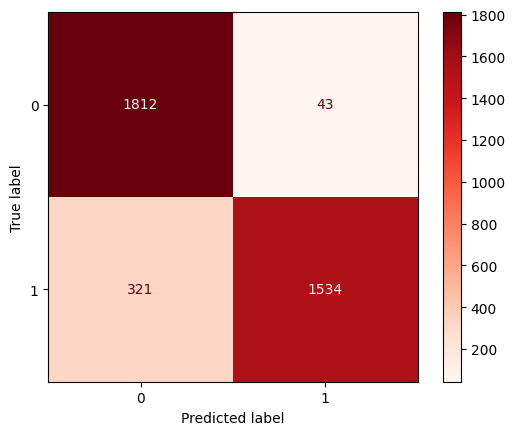

In [56]:
#see the results of data that has been trained using the random search method
y_pred_train_finals = knn_randomcv_best.predict(X_train_finals)

print('F1 Score - Train Set  : ', f1_score(y_trains, y_pred_train_finals), '\n')
print('Classification Report : \n', classification_report(y_trains, y_pred_train_finals), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_randomcv, X_train_finals, y_trains, cmap='Reds'))

F1 Score - Test Set  :  0.4571428571428572 

Classification Report : 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       466
           1       0.47      0.44      0.46       127

    accuracy                           0.78       593
   macro avg       0.66      0.65      0.66       593
weighted avg       0.77      0.78      0.77       593
 

Confusion Matrix      : 


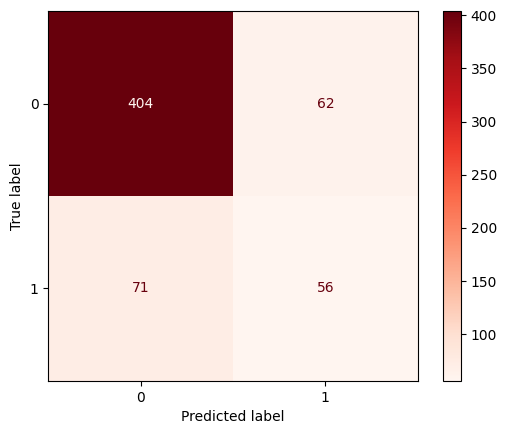

In [57]:
#display test data results using the random search method
y_pred_test_finals = knn_randomcv_best.predict(X_test_final)

print('F1 Score - Test Set  : ', f1_score(y_test, y_pred_test_finals), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test_finals), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(knn_randomcv, X_test_final, y_test, cmap='Reds'))

Conclusion: Judging from the default value of KNN f1_score random search has a train range value of 0.89 and test 0.46

# ix Model Evaluation

In [58]:
#Create a new default table to later compare with the default F1 score test value and the one that was used using random search
all_reports = {}
def performance_report(all_reports, y_trains, y_train_predict_knn, y_test, y_test_predict_knn, name):
  score_reports = {
      'train - precision' : precision_score(y_trains, y_train_predict_knn),
      'train - recall' : recall_score(y_trains, y_train_predict_knn),
      'train - accuracy' : accuracy_score(y_trains, y_train_predict_knn),
      'train - f1_score' : f1_score(y_trains, y_train_predict_knn),
      'test - precision' : precision_score(y_test, y_test_predict_knn),
      'test - recall' : recall_score(y_test, y_test_predict_knn),
      'test - accuracy_score' : accuracy_score(y_test, y_test_predict_knn),
      'test - f1_score' : f1_score(y_test, y_test_predict_knn),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_trains, y_train_predict_knn, y_test, y_test_predict_knn, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
test - accuracy_score,0.772344
test - f1_score,0.478764
test - precision,0.469697
test - recall,0.488189
train - accuracy,0.802965
train - f1_score,0.785568
train - precision,0.861647
train - recall,0.721833


In [59]:
#displays a comparison table of values ​​from the default f1 test and the random search method
all_reports = performance_report(all_reports, y_trains, y_pred_train_finals, y_test, y_pred_test_finals, 'Random Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Random Search
train - precision,0.861647,0.972733
train - recall,0.721833,0.826954
train - accuracy,0.802965,0.901887
train - f1_score,0.785568,0.893939
test - precision,0.469697,0.474576
test - recall,0.488189,0.440945
test - accuracy_score,0.772344,0.775717
test - f1_score,0.478764,0.457143


Hadil: From the results, it can be concluded that for the F1score test, the better KNN model is the default one. So the model that will be used in data inference to predict whether the user will successfully pay or not is the default KNN

In [60]:
#define the KNN function that has been hyperparameter tuned with the random search function to be saved in the pkl file
model_knn=KNeighborsClassifier().fit(X_train_finals,y_trains)

# x. Model Saving

In [61]:
# Model Saving

with open('scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)

with open('model_knn.pkl', 'wb') as file_2:
  pickle.dump(model_knn, file_2)